## Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning

## Contexte

Vous êtesingénieur IA chez "Marketing Intelligence Consulting", une entreprise de conseil spécialisée sur les problématiques de marketing digital.

"Air Paradis" a missionné votre cabinet pour créer un produit IA permettant d’anticiper les bad buzz sur les réseaux sociaux en permettant de prédire le sentiment associé à un tweet.

Marc, votre manager, vous demande de tester plusieurs approches :
- approche “Modèle sur mesure simple”, pour développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.
- approche “Modèle sur mesure avancé” pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet. => C’est ce modèle qui sera déployé et montré à Air Paradis.

Une démarche MLOPS devra être mis en oeuvre.

Le déploiement selon un pipeline continu du modèle via API intègrera également des tests unitaires automatisés.

Un suivi de performance du modèle en production sera également mis en place.

## Librairies utilisées avec le langage Python :

In [1]:
!pip install mlflow
!pip install pyngrok

In [2]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import ast
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score, accuracy_score, make_scorer
import mlflow
import mlflow.sklearn
import shutil
from IPython.display import FileLink
from pyngrok import ngrok
import gc
import os
import subprocess
import webbrowser
import time
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# RaZ des runs mlflow
# shutil.rmtree('D:/tutorial-env/OCR/Projet7/mlruns', ignore_errors=True)

# Création répertoire local pour les logs MLFlow
# local_path = "D:/tutorial-env/OCR/Projet7/mlruns"
local_path = "/content/drive/MyDrive/Colab Notebooks/mlruns"
os.makedirs(local_path,exist_ok=True)

mlflow.set_tracking_uri(f"file:///{local_path}")
mlflow.set_experiment("test_RL")

<Experiment: artifact_location='file:////content/drive/MyDrive/Colab Notebooks/mlruns/243406053383681784', creation_time=1737372780943, experiment_id='243406053383681784', last_update_time=1737372780943, lifecycle_stage='active', name='test_RL', tags={}>

## Données :

In [ ]:
# Importation de data :
# X_train = pd.read_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xtrain_preprocessed.csv')
# X_test = pd.read_csv('D:/tutorial-env/OCR/Projet7/csv_p7_Xtest_preprocessed.csv')
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv_p7_Xtrain_preprocessed.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv_p7_Xtest_preprocessed.csv')

In [ ]:
X_train.head()

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation,token_by_tweet_finalised_sans_racinisation
0,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"['blood', 'red', 'half', 'moon', 'beatl', 'lan...","['blood', 'red', 'half', 'moon', 'beatl', 'lan...","['blood', 'red', 'half', 'moon', 'beatle', 'la...","['blood', 'red', 'half', 'moon', 'saint', 'med..."
1,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"['tens', 'genuin', 'fear', 'spontan', 'combust...","['tens', 'genuin', 'fear', 'spontan', 'combust...","['tense', 'genuinely', 'fear', 'spontaneously'...","['fear', 'left', 'worn', 'better', 'shoes_worn']"
2,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,['revis'],['revis'],['revision'],[]
3,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"['squish', 'remind', 'gloriou', 'media', 'room...","['squish', 'remind', 'gloriou', 'media', 'room...","['squishes', 'reminds', 'glorious', 'media', '...","['glorious', 'media', 'room', 'couch', 'liverp..."
4,1,watching letterman and talking,31,watching letterman and talking,"['watch', 'letterman', 'talk', 'watching_lette...","['watch', 'letterman', 'talk', 'watching_lette...","['watching', 'letterman', 'talking', 'watching...","['letterman', 'watching_letterman']"


In [ ]:
typ = type(X_train['token_by_tweet_finalised'][0])
print(f'le type de la colonne token_by_tweet_finalised est :{typ}')

le type de la colonne token_by_tweet_finalised est :<class 'str'>


On va transformer la chaine de caractère en liste de tokens comme initialement, puis on les retransformera en chaine de caractères sans les "codes" de la liste ( [ , ' )

In [ ]:
# Conversion en liste de tokens (et non plus str) comme initialement
X_train['token_by_tweet_finalised'] = X_train['token_by_tweet_finalised'].apply(lambda x: ast.literal_eval(x))
X_test['token_by_tweet_finalised'] = X_test['token_by_tweet_finalised'].apply(lambda x: ast.literal_eval(x))

X_train['token_by_tweet_finalised_sans_racinisation'] = X_train['token_by_tweet_finalised_sans_racinisation'].apply(lambda x: ast.literal_eval(x))
X_test['token_by_tweet_finalised_sans_racinisation'] = X_test['token_by_tweet_finalised_sans_racinisation'].apply(lambda x: ast.literal_eval(x))

X_train.head()

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation,token_by_tweet_finalised_sans_racinisation
0,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"['blood', 'red', 'half', 'moon', 'beatl', 'lan...","[blood, red, half, moon, beatl, land, saint, m...","['blood', 'red', 'half', 'moon', 'beatle', 'la...","[blood, red, half, moon, saint, medal, neck, b..."
1,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"['tens', 'genuin', 'fear', 'spontan', 'combust...","[tens, genuin, fear, spontan, combust, left, s...","['tense', 'genuinely', 'fear', 'spontaneously'...","[fear, left, worn, better, shoes_worn]"
2,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,['revis'],[revis],['revision'],[]
3,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"['squish', 'remind', 'gloriou', 'media', 'room...","[squish, remind, gloriou, media, room, comfi, ...","['squishes', 'reminds', 'glorious', 'media', '...","[glorious, media, room, couch, liverpool, medi..."
4,1,watching letterman and talking,31,watching letterman and talking,"['watch', 'letterman', 'talk', 'watching_lette...","[watch, letterman, talk, watching_letterman]","['watching', 'letterman', 'talking', 'watching...","[letterman, watching_letterman]"


In [ ]:
typ = type(X_train['token_by_tweet_finalised'][0])
print(f'le type de la colonne token_by_tweet_finalised est :{typ}')

le type de la colonne token_by_tweet_finalised est :<class 'list'>


In [ ]:
# Convertir les listes de tokens en texte pour le vecteurisateur
X_train['token_by_tweet_finalised_str'] = X_train['token_by_tweet_finalised'].apply(lambda tokens: ' '.join(tokens))
X_test['token_by_tweet_finalised_str'] = X_test['token_by_tweet_finalised'].apply(lambda tokens: ' '.join(tokens))

X_train['token_by_tweet_finalised_sans_racinisation_str'] = X_train['token_by_tweet_finalised_sans_racinisation'].apply(lambda tokens: ' '.join(tokens))
X_test['token_by_tweet_finalised_sans_racinisation_str'] = X_test['token_by_tweet_finalised_sans_racinisation'].apply(lambda tokens: ' '.join(tokens))

X_train.head()

,target,text,len_text,tweet_preprocess,token_by_tweet_temp,token_by_tweet_finalised,token_by_tweet_temp_sans_racinisation,token_by_tweet_finalised_sans_racinisation,token_by_tweet_finalised_str,token_by_tweet_finalised_sans_racinisation_str
0,0,Its a Blood red half moon. A beatle Landed on ...,120,Its a Blood red half moon. A beatle Landed on ...,"['blood', 'red', 'half', 'moon', 'beatl', 'lan...","[blood, red, half, moon, beatl, land, saint, m...","['blood', 'red', 'half', 'moon', 'beatle', 'la...","[blood, red, half, moon, saint, medal, neck, b...",blood red half moon beatl land saint medal rip...,blood red half moon saint medal neck bad sign ...
1,0,I'm so tense today I genuinely fear spontaneou...,138,I'm so tense today I genuinely fear spontaneou...,"['tens', 'genuin', 'fear', 'spontan', 'combust...","[tens, genuin, fear, spontan, combust, left, s...","['tense', 'genuinely', 'fear', 'spontaneously'...","[fear, left, worn, better, shoes_worn]",tens genuin fear spontan combust left shoe wor...,fear left worn better shoes_worn
2,0,Is doing revision...AGAIN!!,28,Is doing revision...AGAIN!!,['revis'],[revis],['revision'],[],revis,
3,1,@manuanya it just. *squishes* reminds me of ou...,98,it just. *squishes* reminds me of our glorious...,"['squish', 'remind', 'gloriou', 'media', 'room...","[squish, remind, gloriou, media, room, comfi, ...","['squishes', 'reminds', 'glorious', 'media', '...","[glorious, media, room, couch, liverpool, medi...",squish remind gloriou media room comfi couch l...,glorious media room couch liverpool media_room...
4,1,watching letterman and talking,31,watching letterman and talking,"['watch', 'letterman', 'talk', 'watching_lette...","[watch, letterman, talk, watching_letterman]","['watching', 'letterman', 'talking', 'watching...","[letterman, watching_letterman]",watch letterman talk watching_letterman,letterman watching_letterman


In [ ]:
typ = type(X_train['token_by_tweet_finalised_str'][0])
print(f'le type de la colonne token_by_tweet_finalised_str est :{typ}')

le type de la colonne token_by_tweet_finalised_str est :<class 'str'>


## Vectorisation :

### CountVectorizer avec racinisation

In [ ]:
# Vectorisation
model = CountVectorizer() #on limite le vocabulaire pour des questions de coûts mémoire
X_train_vec_count = model.fit_transform(X_train['token_by_tweet_finalised_str'])
X_test_vec_count = model.transform(X_test['token_by_tweet_finalised_str'])
# On garde la matrice creuse et on ne la transforme pas en dense (dataframe) pour limiter le coût mémoire

print(f"Dimension de la matrice creuse de X_train_vec_count : {X_train_vec_count.shape}")
print(f"Dimension de la matrice creuse de X_test_vec_count : {X_test_vec_count.shape}")

Dimension de la matrice creuse de X_train_vec_count : (128000, 340037)
Dimension de la matrice creuse de X_test_vec_count : (40000, 340037)


### CountVectorizer sans racinisation

In [ ]:
# Vectorisation
model = CountVectorizer() #on limite le vocabulaire pour des questions de coûts mémoire
X_train_vec_sansracinisation_count = model.fit_transform(X_train['token_by_tweet_finalised_sans_racinisation_str'])
X_test_vec_sansracinisation_count = model.transform(X_test['token_by_tweet_finalised_sans_racinisation_str'])
# On garde la matrice creuse et on ne la transforme pas en dense (dataframe) pour limiter le coût mémoire

print(f"Dimension de la matrice creuse de X_train_vec_sansracinisation_count : {X_train_vec_sansracinisation_count.shape}")
print(f"Dimension de la matrice creuse de X_test_vec_sansracinisation_count : {X_test_vec_sansracinisation_count.shape}")

Dimension de la matrice creuse de X_train_vec_sansracinisation_count : (128000, 179591)
Dimension de la matrice creuse de X_test_vec_sansracinisation_count : (40000, 179591)


### Tf-idf avec racinisation

In [ ]:
# Vectorisation
model = TfidfVectorizer() #on limite le vocabulaire pour des questions de coûts mémoire
X_train_vec_tfidf = model.fit_transform(X_train['token_by_tweet_finalised_str'])
X_test_vec_tfidf = model.transform(X_test['token_by_tweet_finalised_str'])
# On garde la matrice creuse et on ne la transforme pas en dense (dataframe) pour limiter le coût mémoire

print(f"Dimension de la matrice creuse de X_train_vec_tfidf : {X_train_vec_tfidf.shape}")
print(f"Dimension de la matrice creuse de X_test_vec_tfidf : {X_test_vec_tfidf.shape}")

Dimension de la matrice creuse de X_train_vec_tfidf : (128000, 340037)
Dimension de la matrice creuse de X_test_vec_tfidf : (40000, 340037)


### Tf-idf sans racinisation

In [ ]:
# Vectorisation
model = TfidfVectorizer() #on limite le vocabulaire pour des questions de coûts mémoire
X_train_vec_sansracinisation_tfidf = model.fit_transform(X_train['token_by_tweet_finalised_sans_racinisation_str'])
X_test_vec_sansracinisation_tfidf = model.transform(X_test['token_by_tweet_finalised_sans_racinisation_str'])
# On garde la matrice creuse et on ne la transforme pas en dense (dataframe) pour limiter le coût mémoire

print(f"Dimension de la matrice creuse de X_train_vec_sansracinisation_tfidf : {X_train_vec_sansracinisation_tfidf.shape}")
print(f"Dimension de la matrice creuse de X_test_vec_sansracinisation_tfidf : {X_test_vec_sansracinisation_tfidf.shape}")

Dimension de la matrice creuse de X_train_vec_sansracinisation_tfidf : (128000, 179591)
Dimension de la matrice creuse de X_test_vec_sansracinisation_tfidf : (40000, 179591)


Etant dans une démarche de classification supervisée, nous ne ferons pas de réduction de dimension.

## Clustering par régression logistique:

In [ ]:
# Création d'un dictionnaire regroupant les jeu de train et de test correspondant aux differentes vectorisation

vec = {
    "count": {"train": X_train_vec_count, "test": X_test_vec_count},
    "count_sansracinisation": {"train": X_train_vec_sansracinisation_count, "test": X_test_vec_sansracinisation_count},
    "tfidf": {"train": X_train_vec_tfidf, "test": X_test_vec_tfidf},
    "tfidf_sansracinisation": {"train": X_train_vec_sansracinisation_tfidf, "test": X_test_vec_sansracinisation_tfidf}
    }



Test Accuracy: 0.7606
Test Recall: 0.7928
Test F1-score: 0.7681
Test ROC AUC: 0.8368

Classification Report avec count (Test):
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     19993
           1       0.74      0.79      0.77     20007

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



2025/02/07 14:20:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métrique de count enregistrés dans MLFlow

Test Accuracy: 0.7272
Test Recall: 0.7762
Test F1-score: 0.7400
Test ROC AUC: 0.8020

Classification Report avec count_sansracinisation (Test):
              precision    recall  f1-score   support

           0       0.75      0.68      0.71     19993
           1       0.71      0.78      0.74     20007

    accuracy                           0.73     40000
   macro avg       0.73      0.73      0.73     40000
weighted avg       0.73      0.73      0.73     40000



2025/02/07 15:04:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métrique de count_sansracinisation enregistrés dans MLFlow

Test Accuracy: 0.7614
Test Recall: 0.7696
Test F1-score: 0.7634
Test ROC AUC: 0.8426

Classification Report avec tfidf (Test):
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     19993
           1       0.76      0.77      0.76     20007

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



2025/02/07 15:34:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métrique de tfidf enregistrés dans MLFlow

Test Accuracy: 0.7259
Test Recall: 0.7606
Test F1-score: 0.7352
Test ROC AUC: 0.8028

Classification Report avec tfidf_sansracinisation (Test):
              precision    recall  f1-score   support

           0       0.74      0.69      0.72     19993
           1       0.71      0.76      0.74     20007

    accuracy                           0.73     40000
   macro avg       0.73      0.73      0.73     40000
weighted avg       0.73      0.73      0.73     40000



2025/02/07 16:03:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle et métrique de tfidf_sansracinisation enregistrés dans MLFlow


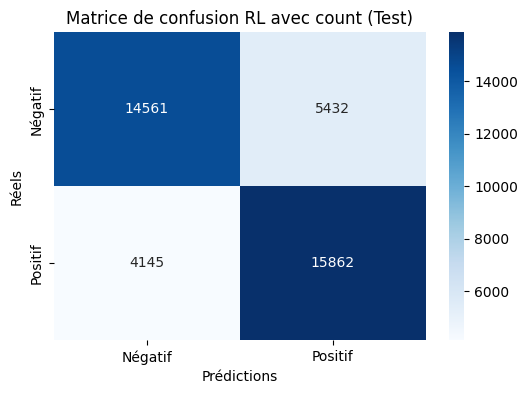

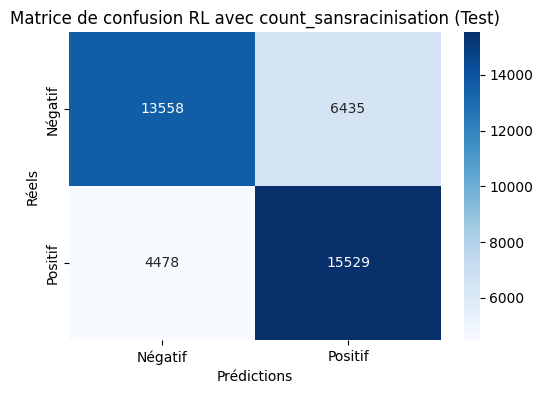

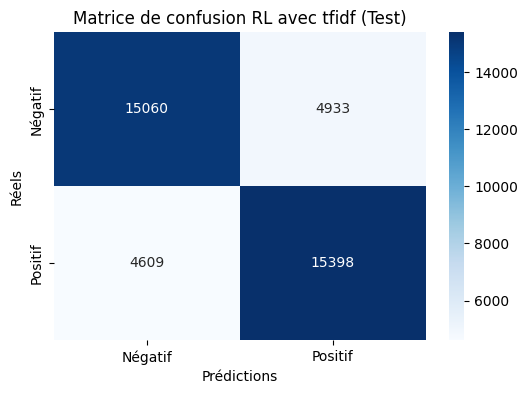

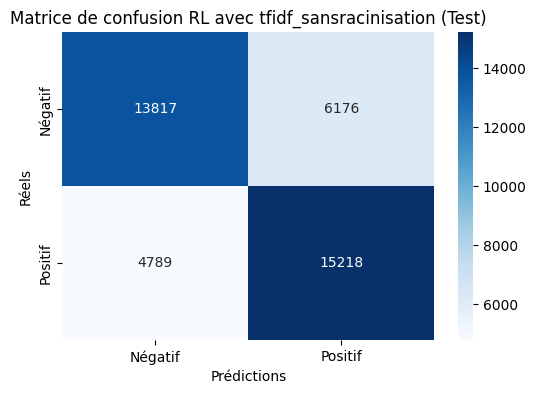

In [ ]:
for name,_ in vec.items():
  # Activation de MLFlow
  with mlflow.start_run(experiment_id='243406053383681784', run_name=f"{name}"):
    # Instance de régression logistique
    model = LogisticRegressionCV( max_iter = 1000, random_state=42)

    # Enregistrer les hyperparamètres
    mlflow.log_param("model_type", "LogisticRegressionCV")
    mlflow.log_param("max_iter", 1000)

    # Validation croisée avec métriques supplémentaires
    accuracies = cross_val_score(model, vec[name]["train"], X_train.target, cv=5, scoring="accuracy")
    recalls = cross_val_score(model, vec[name]["train"], X_train.target, cv=5, scoring=make_scorer(recall_score))
    f1_scores = cross_val_score(model, vec[name]["train"], X_train.target, cv=5, scoring="f1")
    roc_aucs = cross_val_score(model, vec[name]["train"], X_train.target, cv=5, scoring="roc_auc")

    # Calculer la moyenne et l'écart-type des métriques
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mean_roc_auc = np.mean(roc_aucs)
    std_roc_auc = np.std(roc_aucs)

    # Journalisation des métriques dans MLflow
    mlflow.log_metric("accuracy_mean", mean_accuracy)
    mlflow.log_metric("accuracy_std", std_accuracy)
    mlflow.log_metric("recall_mean", mean_recall)
    mlflow.log_metric("recall_std", std_recall)
    mlflow.log_metric("f1_mean", mean_f1)
    mlflow.log_metric("f1_std", std_f1)
    mlflow.log_metric("roc_auc_mean", mean_roc_auc)
    mlflow.log_metric("roc_auc_std", std_roc_auc)

    # Entrainement
    model.fit(vec[name]["train"], X_train.target)

    # Prediction
    y_pred = model.predict(vec[name]["test"])
    y_pred_proba = model.predict_proba(vec[name]["test"])[:,1]

    test_accuracy = accuracy_score(X_test.target, y_pred)
    test_recall = recall_score(X_test.target, y_pred)
    test_f1 = f1_score(X_test.target, y_pred)
    test_roc_auc = roc_auc_score(X_test.target, y_pred_proba)

    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_roc_auc", test_roc_auc)

    # Matrice de confusion
    conf_matrix = confusion_matrix(X_test.target, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["Négatif", "Positif"],
                yticklabels=["Négatif", "Positif"])
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title(f"Matrice de confusion RL avec {name} (Test)")
    plt.savefig(f"./MyDrive/Colab Notebooks/confusion_matrix_{name}.png")
    mlflow.log_artifact(f"./MyDrive/Colab Notebooks/confusion_matrix_{name}.png")

    # Résumé des métriques
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print(f"\nClassification Report avec {name} (Test):")
    print(classification_report(X_test.target, y_pred))

    # Enregistrement du modèle final
    mlflow.sklearn.log_model(model, "LogisticRegression")

    print(f"Modèle et métrique de {name} enregistrés dans MLFlow")

In [ ]:
# visualisation des logs MLFlow
mlflow.set_tracking_uri("/content/drive/MyDrive/Colab Notebooks/mlruns")
experiments = mlflow.search_experiments()
print(experiments)
print('---------------------------------------------------------------------')
runs = mlflow.search_runs(experiment_ids=['243406053383681784'])
print(runs)

[<Experiment: artifact_location='file:////content/drive/MyDrive/Colab Notebooks/mlruns/243406053383681784', creation_time=1737372780943, experiment_id='243406053383681784', last_update_time=1737372780943, lifecycle_stage='active', name='test_RL', tags={}>]
---------------------------------------------------------------------
                              run_id       experiment_id    status  \
0   42854c5b9d254f1bb6fd1bdf7b2385ba  243406053383681784  FINISHED   
1   67b3672ca215476da09f4feaa1c5f495  243406053383681784  FINISHED   
2   02bada09aab44c35b147a54d6da6e804  243406053383681784  FINISHED   
3   7a7cef00f7ab4bc386ff6aec28778e19  243406053383681784  FINISHED   
4   11acabef7a9945b7a41ac4c2b5213d82  243406053383681784   RUNNING   
5   74b68be521084fca8b0af920c808d9eb  243406053383681784  FINISHED   
6   84567307dc784f8c889c661621308f5d  243406053383681784  FINISHED   
7   4521a019d2f240ac9bbd77bb7d4c0525  243406053383681784    FAILED   
8   231bb4df93004a99bf1440ee776a5bd0  24340

In [3]:
# On repasse en environnement local après avoir transféré le dossier mlruns en local
# lancement de la fenêtre MLFlow sur le port 5006
process = subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "file:/D:/tutorial-env/OCR/Projet7/mlruns", "--port", "5006"],stdout = subprocess.PIPE, stderr = subprocess.PIPE)
time.sleep(1)
webbrowser.open("http://localhost:5006")
print(f"MLFlow lancé")

MLFlow lancé


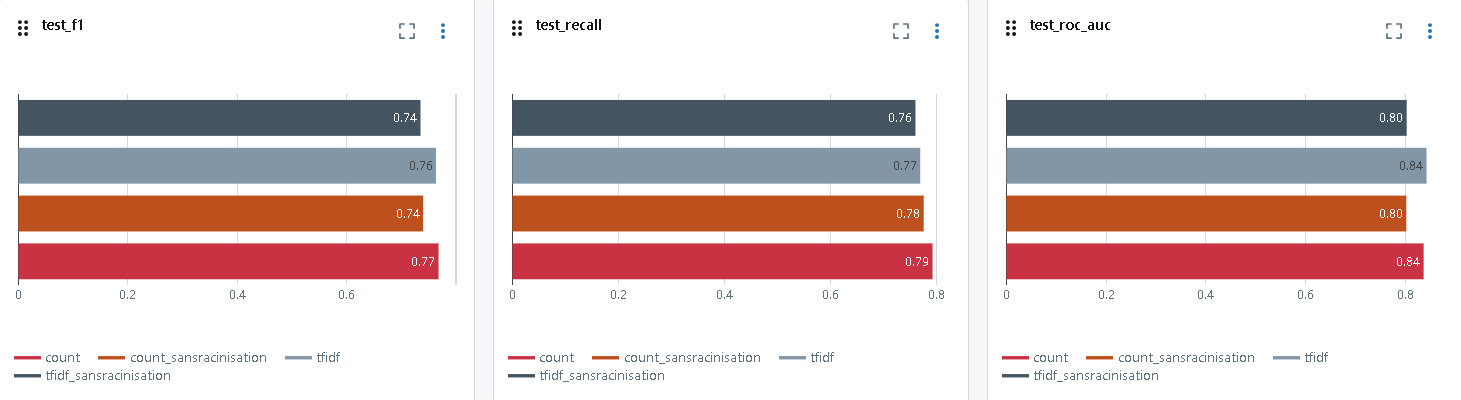
Intéressons-nous aux résultats du jeu de test :

Pour anticiper les bad buzz, nous privilégierons un fort recall pour la classe négative 0 et donc minimiser les Faux Positifs qui correspondent aux bad buzz manqués. Un mauvais score pourrait sous-estimer les bad-buzz et donc nuire à la gestion de l'image de l'entreprise.

Il vaut mieux faussement identifier un message positif (faux negatif) plutôt que de manquer un bad buzz (faux positif).

Ainsi, les meilleurs résultats sont avec la vectorisation Tf-idf avec une racinisation par stemming avec :
- un recall de 75% pour la classe négative,
- un f1 score de 76% (moyenne harmonique entre rappel et precision pour éviter de complètement favoriser l'un par rapport à l'autre)
- et une aire sous la courbe ROC de 0.84 (bonne capacité à distinguer les deux classes),
- la matrice de confusion montre un minimum de 4933 tweets négatifs manqués.


Voici la matrice de confusion  :

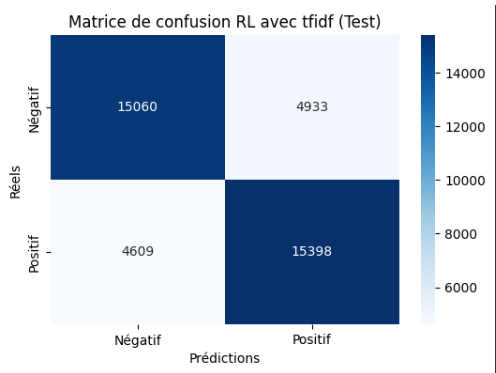

Nous avons environ 10000 faux positifs ou négatifs mais ils sont bien répartis ce qui montre une bonne généralisation.

NB : la métrique ARI n'est pas souvent adapté pour les modèles supervisés.